In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython import display

import matplotlib.pyplot as plt

In [2]:
test_df = pd.read_csv('datasets/test_df.csv').drop(columns='Unnamed: 0')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: datetime.datetime.fromisoformat(x))

train_df = pd.read_csv('datasets/train_df.csv').drop(columns='Unnamed: 0')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: datetime.datetime.fromisoformat(x))

## Proprocessing:
For leveraging predictive models the following features are created:
- $t_e$ - time since previous event
- $t_w$ - time since the beginning of week
- $t_t$ - time since the beginning of trace
- one hot encoded labels

In [3]:
import rl4pm_lib.preprocessing as preprocessing

column_feature = {'tt': 0, 'te': 1, 'tw': 2}
prepro = preprocessing.DfPreprocesser()
prepro.fit(train_df)
train_df_pr = prepro.transform(train_df)
test_df_pr = prepro.transform(test_df)

Also must scale continious (time related features)

In [4]:
scaler = preprocessing.PaperScaler(column_feature)
scaler.fit(train_df_pr)
train_df_pr_sc = scaler.transform(train_df_pr)
test_df_pr_sc = scaler.transform(test_df_pr)

Let's construct features as moving window

In [5]:
win_len = 2
max_window_len = 5

In [6]:
def make_window_features_for_trace(df, win_len):
    _win_len = win_len-1
    out = df[_win_len:].copy()
    out.reset_index(drop=True, inplace=True)
    sh = df.shape[0]
    for _i in range(win_len-1):
        df_to_app = df[_i:sh-_win_len + _i].copy()
        shape_miss = df.shape[0] - df_to_app.shape[0]
        
        rename_dict = {col: col + f'__{_i+1}' for col in df_to_app.columns}
        df_to_app.rename(columns=rename_dict, inplace=True)
        df_to_app.reset_index(drop=True, inplace=True)
        
        out = pd.concat([out, df_to_app], axis=1)
    out.dropna(inplace=True)
    shape_miss = df.shape[0] - out.shape[0]
    return out

In [7]:
def make_window_features(df, win_len):
    traces = list(set(df['trace_id'].values))
    outs = []
    labels = []
    tes = []
    for _i, trace in enumerate(traces):
        _df = df[df['trace_id'] == trace]
        outs.append(make_window_features_for_trace(_df, win_len)[:-1])  # one must left 4 prediction
        labels.append(_df.drop(columns=['te', 'tt', 'tw', 'trace_id']).values.argmax(axis=1)[win_len:])
        tes.append(_df['te'].values[win_len:])
    return pd.concat(outs, axis=0), np.concatenate(labels), np.concatenate(tes)

In [8]:
test_df_pr_sc_win, test_labels, test_tes = make_window_features(test_df_pr_sc, win_len)
test_df_pr_sc_win.drop(columns=['trace_id'], inplace=True)

In [9]:
train_df_pr_sc_win, train_labels, train_tes = make_window_features(train_df_pr_sc, win_len)
train_df_pr_sc_win.drop(columns=['trace_id'], inplace=True)

Ok, features and targets are ready, let's do `.fit()`, `.predict())))))`

What methods will I use? Of course all, which were listed [here](https://github.com/lemikhovalex/DA_CV)

## Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [14]:
%%time
rfc_activ = RandomForestClassifier(n_estimators=130, max_depth=17, random_state=42, n_jobs=-1)

rfc_activ.fit(train_df_pr_sc_win, train_labels)
train_labels_hat = rfc_activ.predict(train_df_pr_sc_win)
test_labels_hat = rfc_activ.predict(test_df_pr_sc_win)

test_acc_rfc = accuracy_score(test_labels_hat, test_labels)
train_acc_rfc = accuracy_score(train_labels_hat, train_labels)
print(f'Random Forest Classifier\ntest  accuracy = {test_acc_rfc: .2f}\ntrain accuracy = {train_acc_rfc: .2f}')

Random Forest Classifier
test  accuracy =  0.84
train accuracy =  0.85
Wall time: 7.72 s


In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': np.linspace(100, 250, num=30, dtype=int),
    'max_depth' : np.linspace(7, 30, num=30, dtype=int),
}

model_gs = RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=model_gs, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
CV_rfc.fit(train_df_pr_sc_win, train_labels)

In [ ]:
CV_rfc.best_params_

In [ ]:
rfc_activ_best = CV_rfc.best_estimator_

rfc_activ_best.fit(train_df_pr_sc_win, train_labels)
train_labels_hat = rfc_activ_best.predict(train_df_pr_sc_win)
test_labels_hat = rfc_activ_best.predict(test_df_pr_sc_win)

In [ ]:
test_acc_rfc = accuracy_score(test_labels_hat, test_labels)
train_acc_rfc = accuracy_score(test_labels_hat, test_labels)
print(f'Random Forest Classifier, after grid search\ntest  accuracy = {test_acc_rfc: .2f}\ntrain accuracy = {train_acc_rfc: .2f}')

Resuls some how are beter then in article on LSTM approach

## K Neighbors Classifier

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

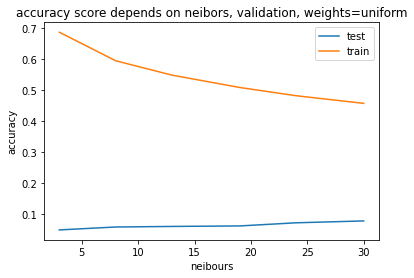

In [60]:
n_n = np.linspace(3, 30, 6, dtype=int)
accuracy_test_scores = []
accuracy_train_scores = []
weights_type = 'uniform'
for _i, n_neib in enumerate(n_n):
    knn_model = KNeighborsClassifier(n_neighbors=int(n_neib), weights=weights_type, n_jobs=-1)
    scores = cross_validate(knn_model, train_df_pr_sc_win, train_labels,
                            cv=5, scoring='accuracy', return_train_score=True)
    accuracy_test_scores.append(scores['test_score'].mean())
    accuracy_train_scores.append(scores['train_score'].mean())
    
    display.clear_output(wait=True)
    plt.plot(n_n[:_i+1], accuracy_test_scores, label='test')
    plt.plot(n_n[:_i+1], accuracy_train_scores, label='train')
    plt.xlabel('neibours')
    plt.ylabel('accuracy')
    plt.title(f'accuracy score depends on neibors, validation, weights={weights_type}')
    plt.legend()
    plt.show()
    
_d = pd.DataFrame()
_d['n_n'] = n_n
_d['test_accuracy'] = accuracy_test_scores
_d['train_accuracy'] = accuracy_train_scores
_d.to_csv(f'cv_data/dist_knn_{weights_type}.csv')

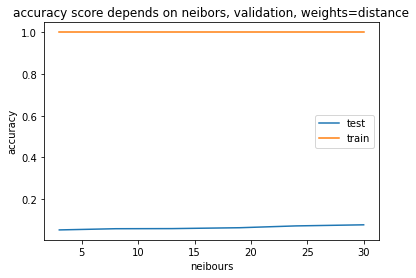

In [62]:
n_n = np.linspace(3, 30, 6, dtype=int)
accuracy_test_scores = []
accuracy_train_scores = []
weights_type = 'distance'
for _i, n_neib in enumerate(n_n):
    knn_model = KNeighborsClassifier(n_neighbors=int(n_neib), weights=weights_type, n_jobs=-1)
    scores = cross_validate(knn_model, train_df_pr_sc_win, train_labels,
                            cv=5, scoring='accuracy', return_train_score=True)
    accuracy_test_scores.append(scores['test_score'].mean())
    accuracy_train_scores.append(scores['train_score'].mean())
    
    display.clear_output(wait=True)
    plt.plot(n_n[:_i+1], accuracy_test_scores, label='test')
    plt.plot(n_n[:_i+1], accuracy_train_scores, label='train')
    plt.xlabel('neibours')
    plt.ylabel('accuracy')
    plt.title(f'accuracy score depends on neibors, validation, weights={weights_type}')
    plt.legend()
    plt.show()
    
_d = pd.DataFrame()
_d['n_n'] = n_n
_d['test_accuracy'] = accuracy_test_scores
_d['train_accuracy'] = accuracy_train_scores
_d.to_csv(f'cv_data/dist_knn_{weights_type}.csv')